LIBRARIES

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings

LOAD DATA

In [2]:
train_path = r"\\wsl.localhost\Ubuntu\home\uai2001\train_titanic.csv"

test_path = r"\\wsl.localhost\Ubuntu\home\uai2001\test_titanic.csv"

In [10]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [5]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S
544,545,0,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S


In [6]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
180,1072,2,"McCrie, Mr. James Matthew",male,30.0,0,0,233478,13.0000,NaN,S
108,1000,3,"Willer, Mr. Aaron (Abi Weller"")""",male,NaN,0,0,3410,8.7125,NaN,S
206,1098,3,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q


As we see before theres some columns with missing values (Age, Cabin, Fare and Embarked)

AGE

In [12]:
df_all["Age"] = pd.to_numeric(df_all['Age'], errors='coerce')

In [15]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


Filling missing values 

In [17]:
df_all['Age'] = df_all['Age'].fillna(
    df_all.groupby(['Sex', 'Pclass'])['Age'].transform('median')
)

EMBARKED

In [21]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


Filling missing values

In [22]:
df_all['Embarked'] =df_all['Embarked'].fillna('S')

FARE

In [23]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [24]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

Filling missing values

In [25]:
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

CABIN

C:\Users\uai20\AppData\Local\Temp\ipykernel_384\2852930576.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = df[deck][pclass][0]


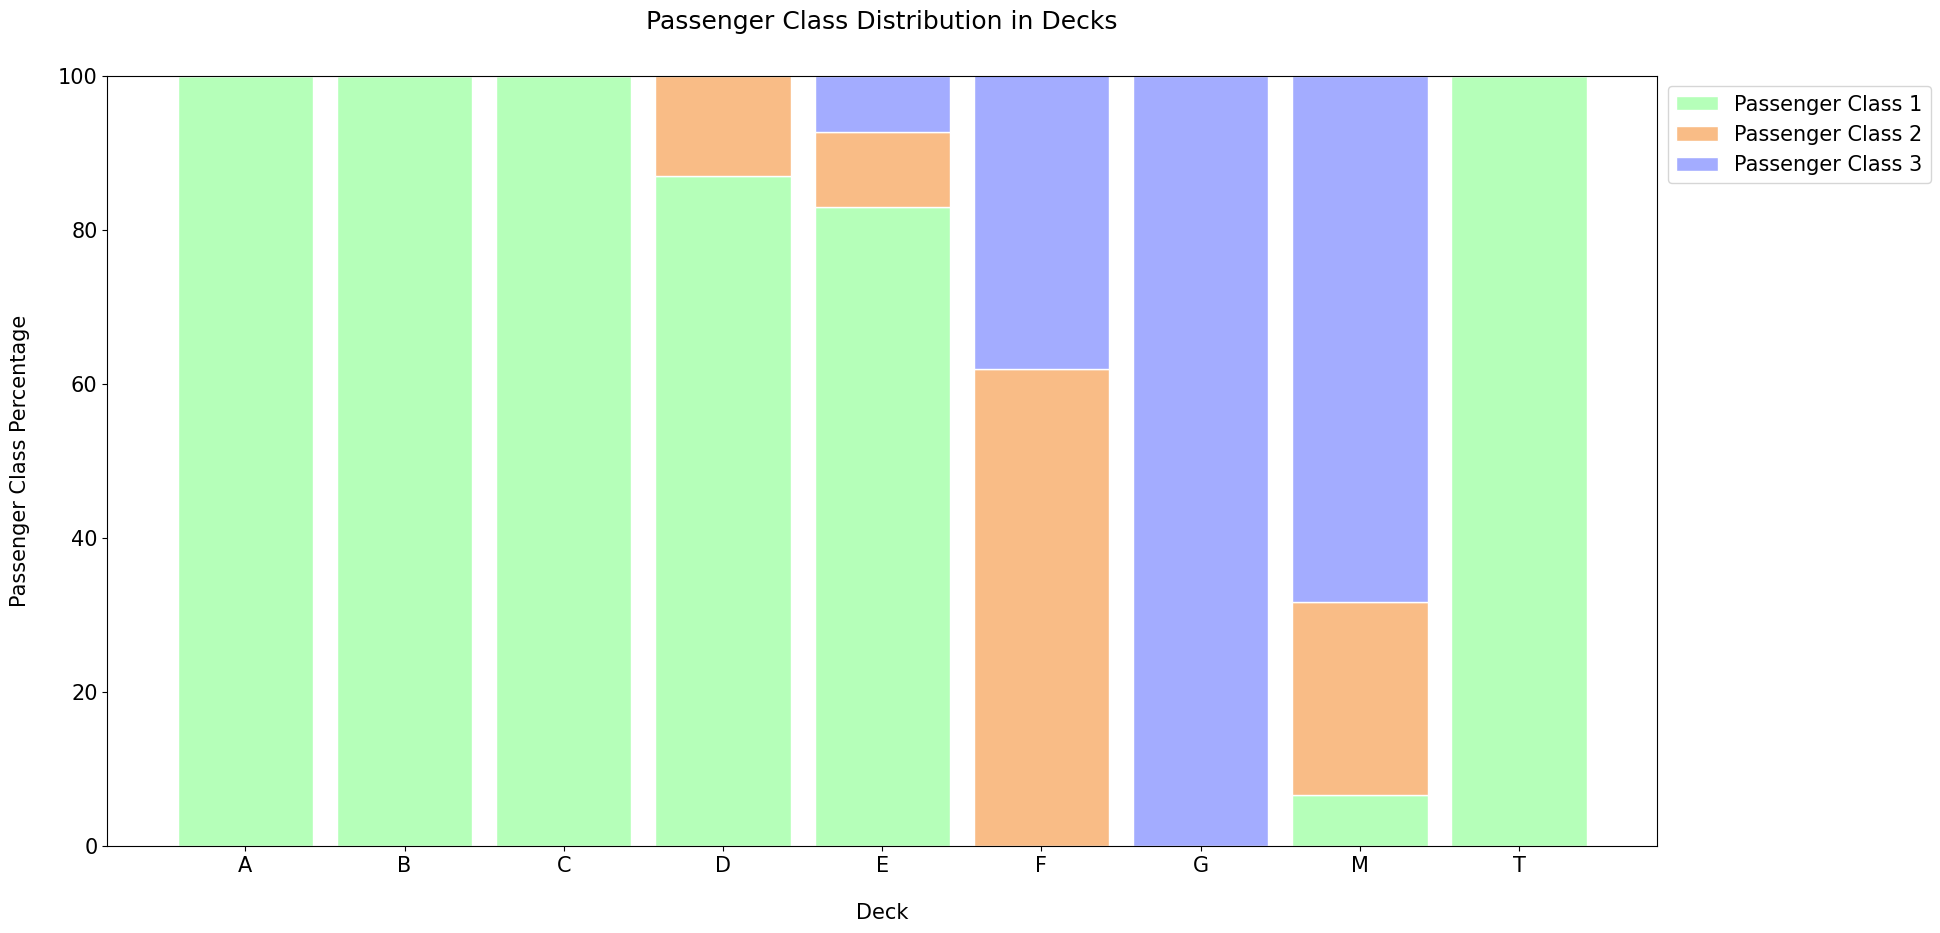

In [29]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [54]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     181
DE       87
FG       26
T         1
Name: count, dtype: int64

In [55]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

In [56]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [58]:
df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




CORRELATIONS

In [59]:
train_corr = df_train.select_dtypes(include='number').corr()
test_corr = df_test.select_dtypes(include='number').corr()

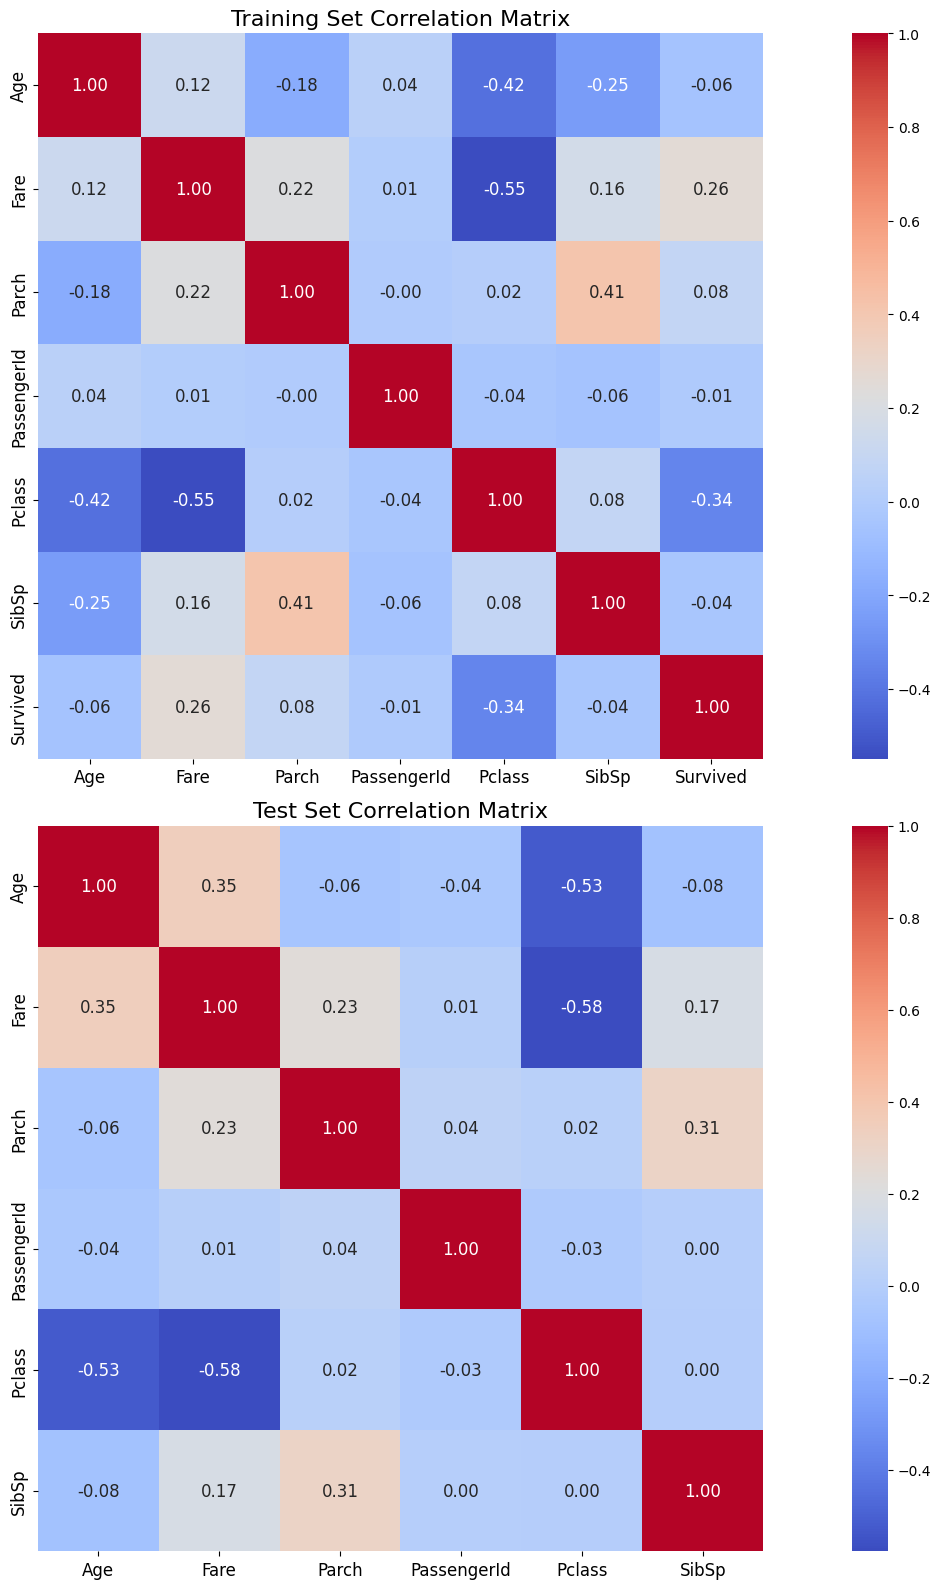

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(18, 16))

sns.heatmap(train_corr, ax=axs[0], annot=True, cmap='coolwarm', square=True, fmt=".2f", annot_kws={'size': 12})
axs[0].set_title('Training Set Correlation Matrix', fontsize=16)

sns.heatmap(test_corr, ax=axs[1], annot=True, cmap='coolwarm', square=True, fmt=".2f", annot_kws={'size': 12})
axs[1].set_title('Test Set Correlation Matrix', fontsize=16)

for ax in axs:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

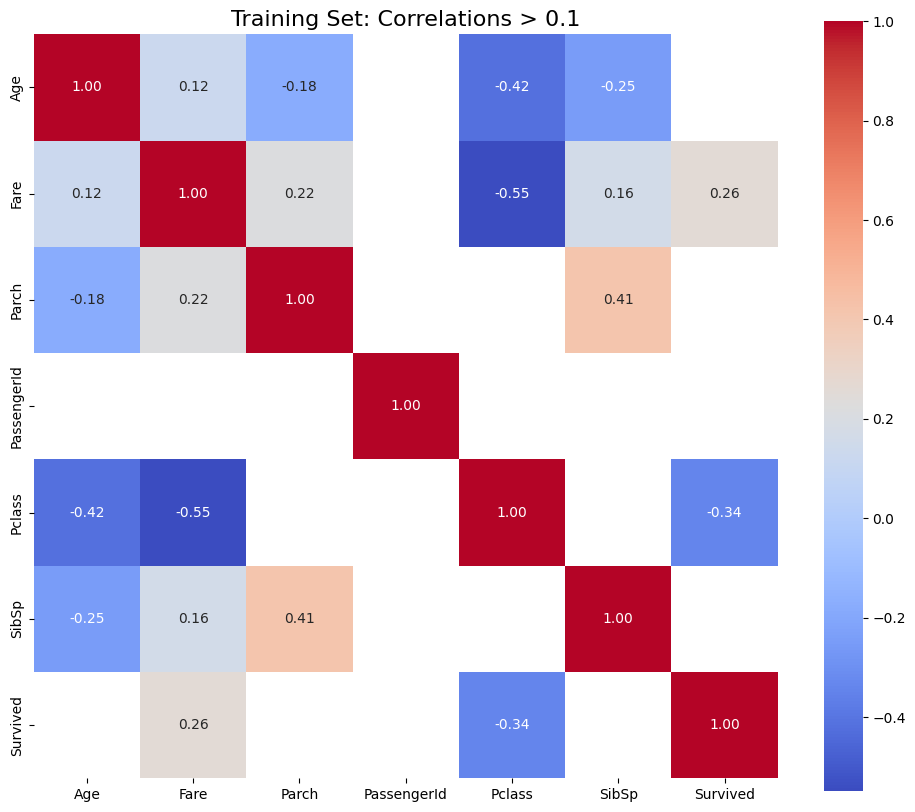

In [61]:
high_corr = train_corr.where((train_corr.abs() > 0.1)).dropna(how='all').dropna(axis=1, how='all')

plt.figure(figsize=(12, 10))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title('Training Set: Correlations > 0.1', fontsize=16)
plt.show()

CONTINOUS FEATURES

C:\Users\uai20\AppData\Local\Temp\ipykernel_384\1489623331.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
C:\Users\uai20\AppData\Local\Temp\ipykernel_384\1489623331.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

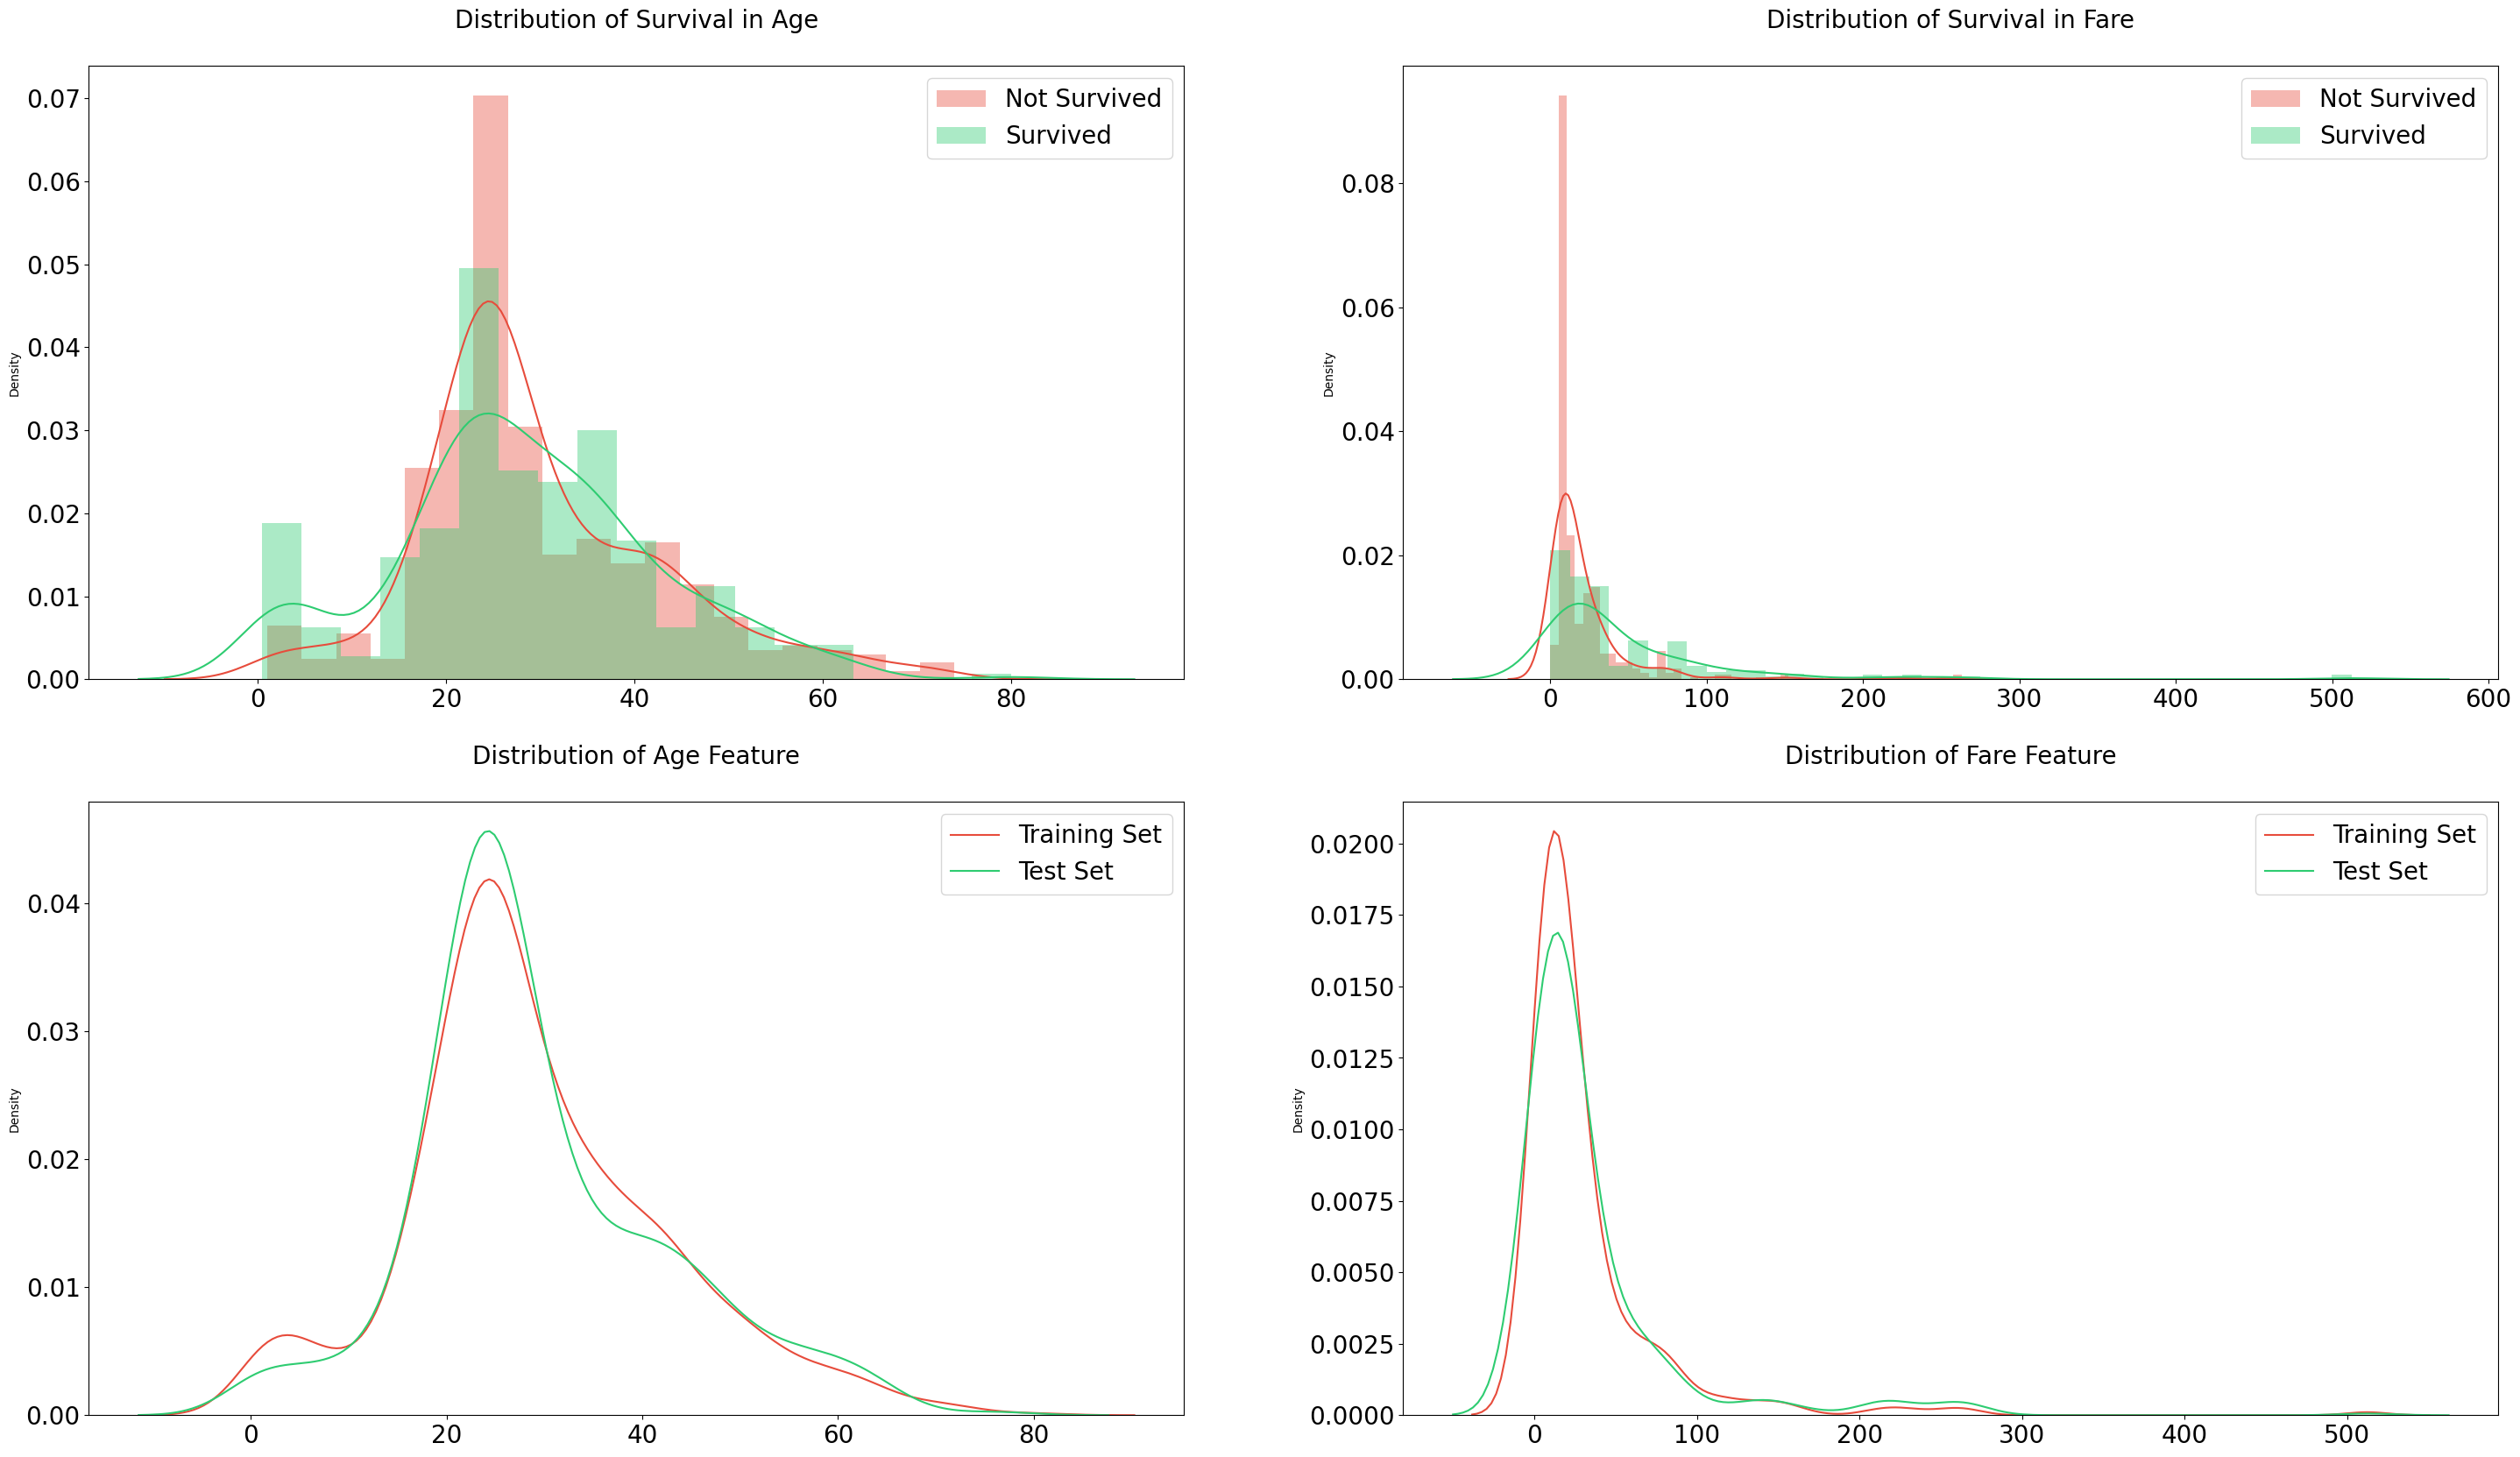

In [62]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

CATEGORICAL FEATURES

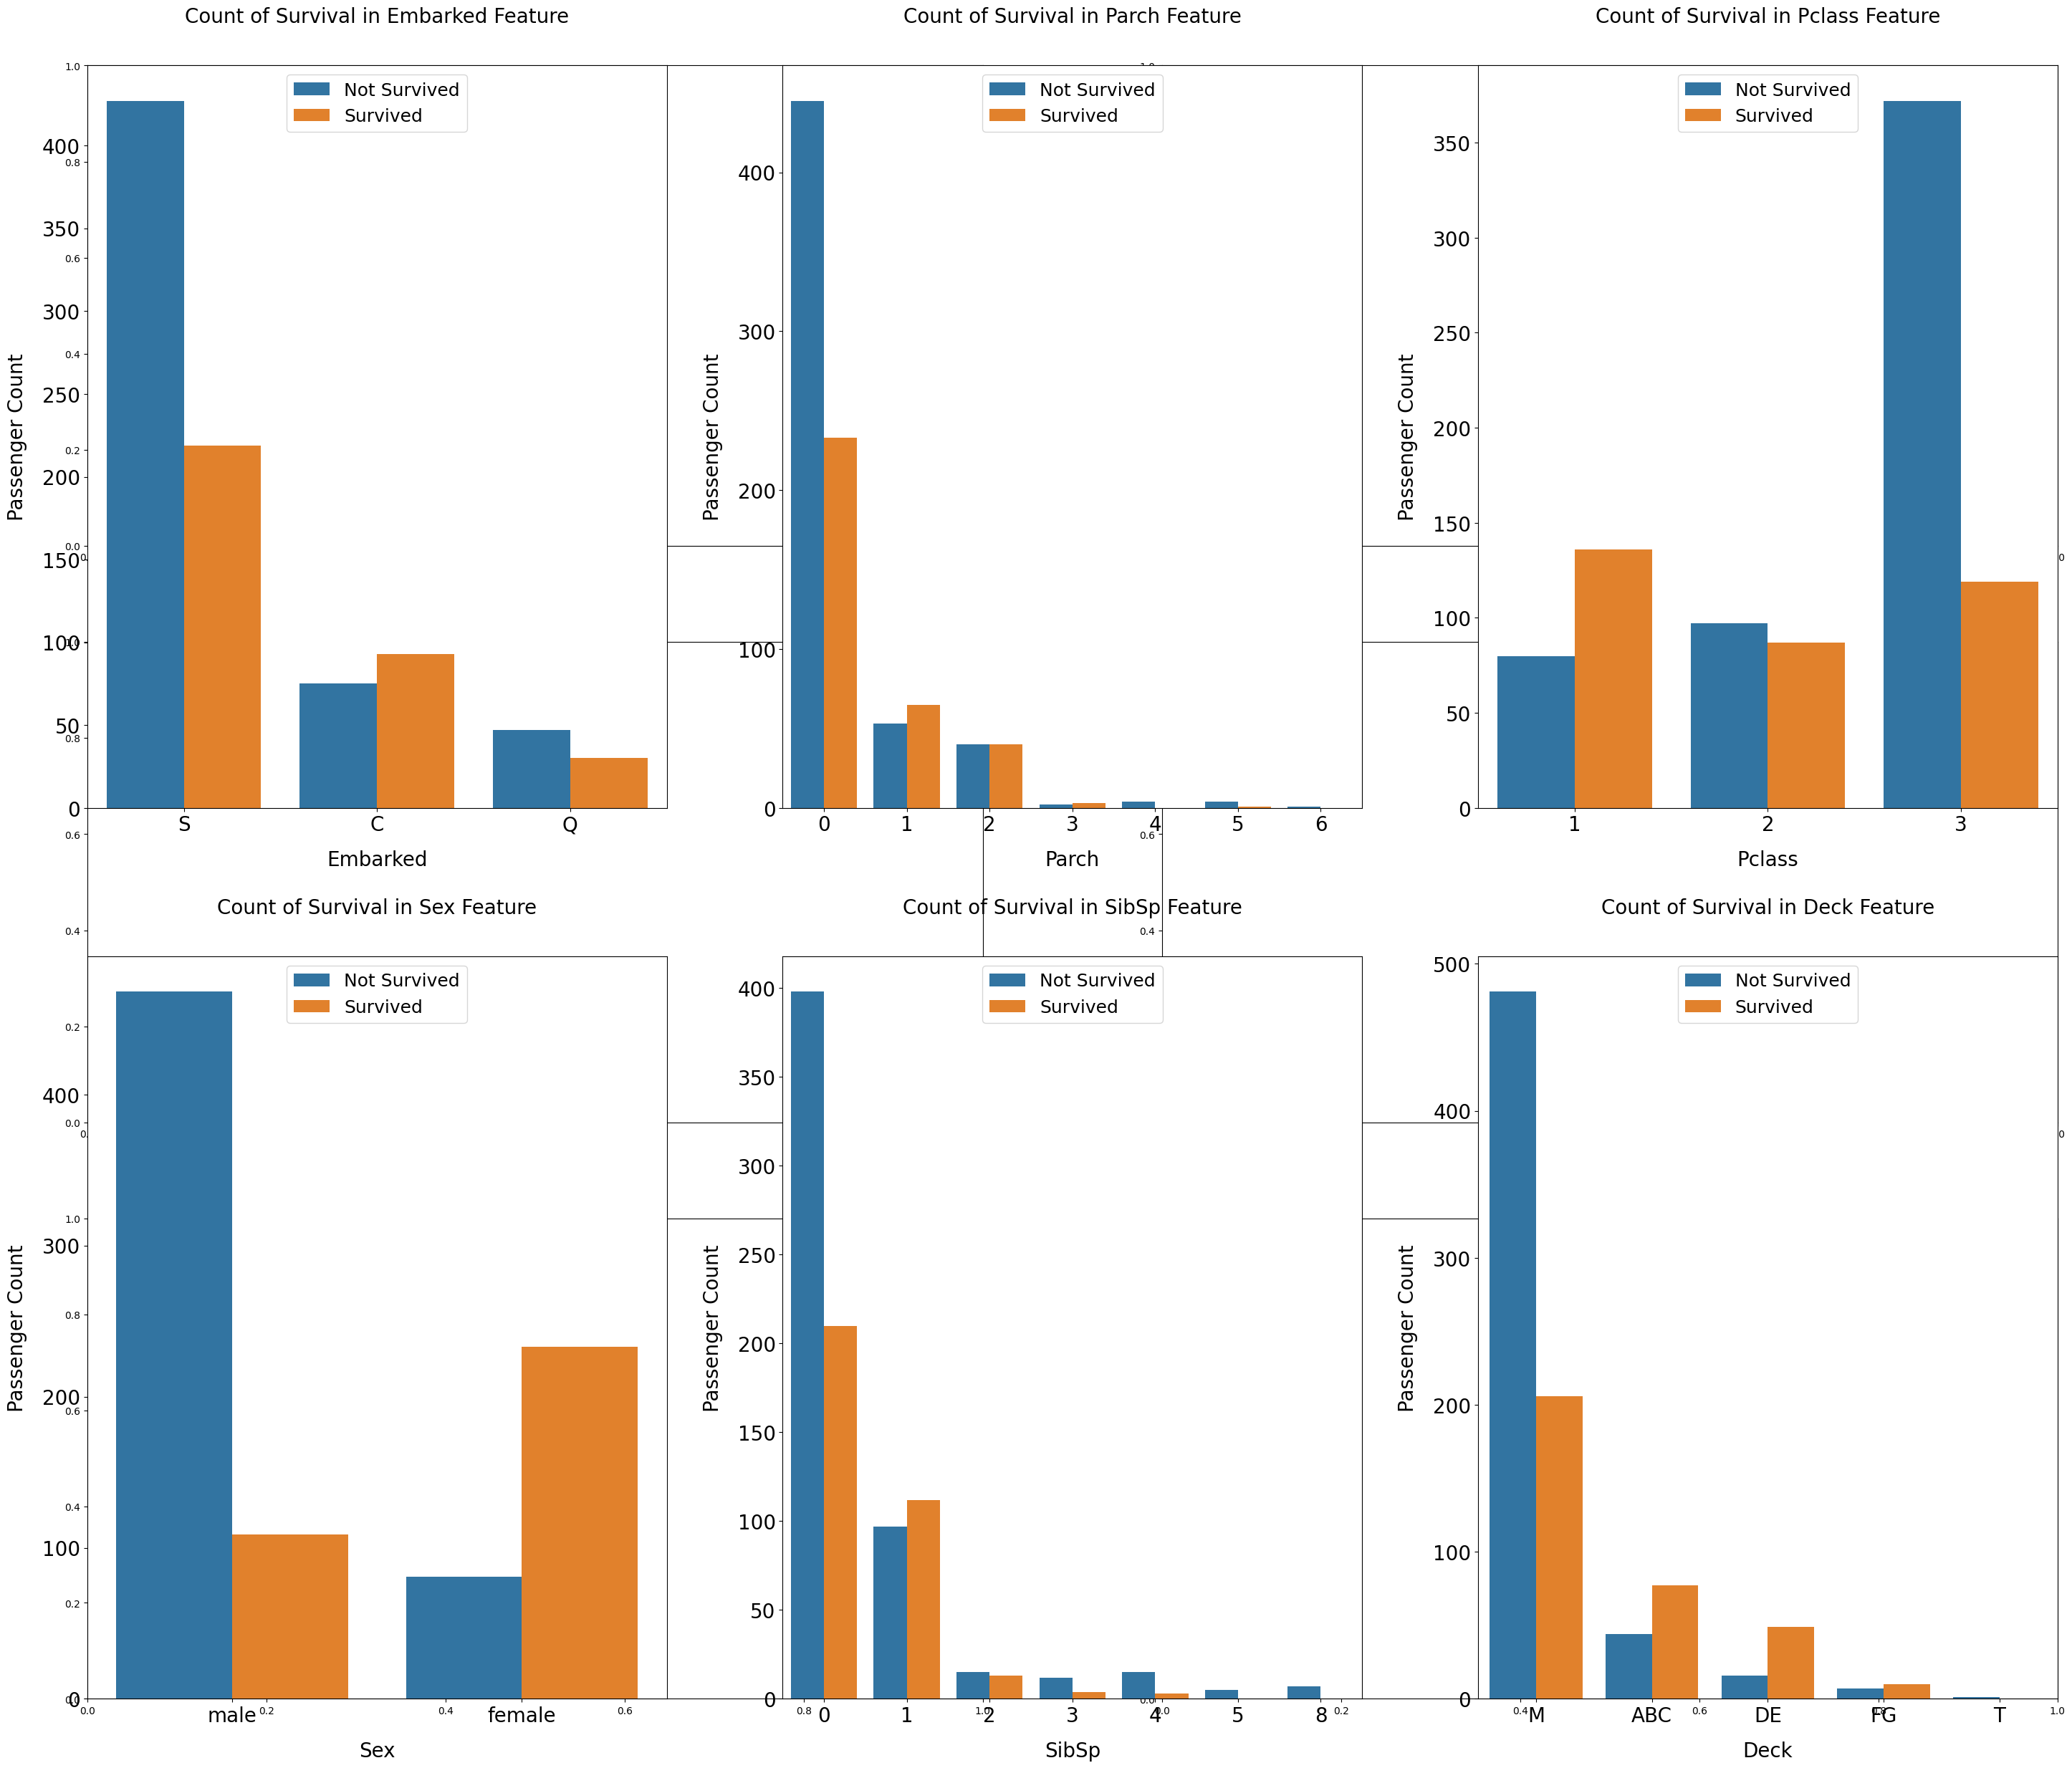

In [63]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

FEATURE ENGINEERING 

We are going to turn the continous values in to categorical

In [64]:
df_all['Fare'] =pd.qcut(df_all['Fare'], 13)

In [65]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

Creating a new column 'Family_Size' adding SibSp + Parch + 1

In [66]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [68]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

Title (Is married?)

In [70]:
df_all['Title'] = df_all['Title'].replace(
    ['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'],
    'Miss/Mrs/Ms'
)
df_all['Title'] = df_all['Title'].replace(
    ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'],
    'Dr/Military/Noble/Clergy'
)

C:\Users\uai20\AppData\Local\Temp\ipykernel_384\3788567248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


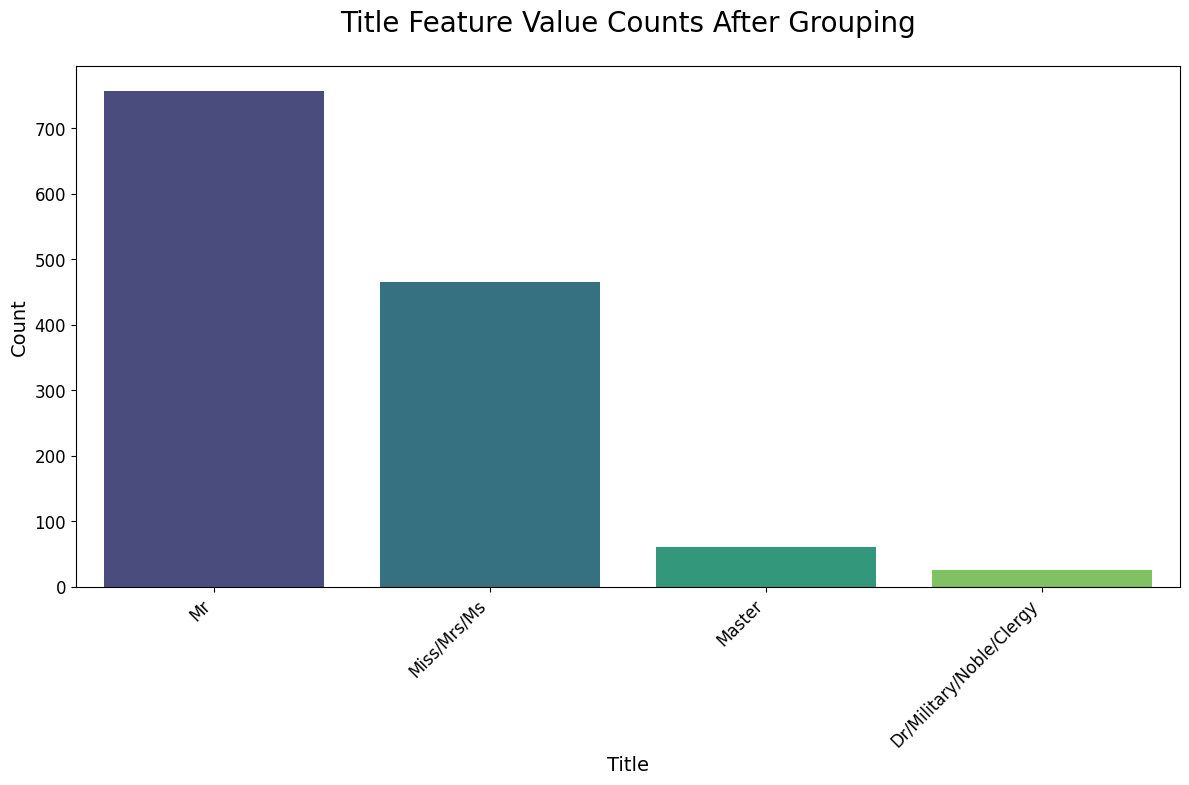

In [71]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x=df_all['Title'].value_counts().index,
    y=df_all['Title'].value_counts().values,
    palette='viridis'
)

plt.title('Title Feature Value Counts After Grouping', size=20, y=1.05)
plt.xlabel('Title', size=14)
plt.ylabel('Count', size=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Now we are going to group passangers in the same family

In [72]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [73]:
df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

LABEL ENCODING

In [74]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']
for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

C:\Users\uai20\AppData\Local\Temp\ipykernel_384\1522544038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = LabelEncoder().fit_transform(df[feature])
C:\Users\uai20\AppData\Local\Temp\ipykernel_384\1522544038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = LabelEncoder().fit_transform(df[feature])
C:\Users\uai20\AppData\Local\Temp\ipykernel_384\1522544038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

ONE HOT ENCODING

In [75]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

In [77]:
for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

MODEL

In [113]:
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title']

drop_cols_t = ['Deck', 'Deck_5' ,'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title']

In [117]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols_t))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 24)
y_train shape: (891,)
X_test shape: (418, 24)


RANDOM FOREST

In [115]:
rf = RandomForestClassifier(criterion='gini', n_estimators=1750, max_depth=7,
                            min_samples_split=6, min_samples_leaf=6, 
                            max_features='sqrt', oob_score=True, random_state=42,
                            n_jobs=-1, verbose=1) 

In [119]:
N = 5
oob_total = 0
probs = pd.DataFrame(0, index=range(len(X_test)), columns=[f'Fold_{i}_Prob_{j}' for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(0, index=df_all.columns, columns=[f'Fold_{i}' for i in range(1, N + 1)])
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    rf.fit(X_train[trn_idx], y_train[trn_idx])
    
    # AUCs
    def compute_auc(rf, X, y):
        return auc(*roc_curve(y, rf.predict_proba(X)[:, 1])[:2])

    trn_auc = compute_auc(rf, X_train[trn_idx], y_train[trn_idx])
    val_auc = compute_auc(rf, X_train[val_idx], y_train[val_idx])
    
    scores.append((trn_auc, val_auc))
    fpr, tpr, _ = roc_curve(y_train[val_idx], rf.predict_proba(X_train[val_idx])[:, 1])
    fprs.append(fpr)
    tprs.append(tpr)

    # Predicciones de test
    test_probs = rf.predict_proba(X_test)
    probs[[f'Fold_{fold}_Prob_0', f'Fold_{fold}_Prob_1']] = test_probs

    # Importancias
    importances = pd.DataFrame(np.zeros((X_train.shape[1] +1, N)), columns=[f'Fold_{i}' for i in range(1, N + 1)], index=X_train_df.columns)

    # OOB
    fold_oob = rf.oob_score_
    oob_total += fold_oob / N
    print(f'Fold {fold} OOB Score: {fold_oob}\n')

print(f'Average OOB Score: {oob_total:.4f}')

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 1 OOB Score: 0.8426966292134831

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 2 OOB Score: 0.8288920056100981

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 3 OOB Score: 0.8373071528751753

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 4 OOB Score: 0.8190743338008415

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 5 OOB Score: 0.820476858345021

Average OOB Score: 0.8297


[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.4s finished


SUBMISSION

In [125]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(5)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
